# Week 2 ‒ 모두의 주차장 데이터를 이용해서 이용자별 향후 이용 건수 예측하기

## 문제 정의
- 목표 : 이용자 별 결제 이력을 바탕으로 향후 이용 건수를 예측하여 마케팅, 영업 등의 의사 결정 과정에 활용
- 예측 과제 : 이용자 별 한 향후 한 달간 이용 건수를 예측하는 Regression 문제 (평가 메트릭 : MSE, MAE)
- 데이터 : 2020.01.01 ~ 2020.12.31 기간에 대한 유저가입정보(유저ID, 가입일), 소비행동정보(상품ID, 점포주소, 결제일, 결제건수), 외부정보(서울시 교통량 데이터, 기상 데이터)

## 주어진 데이터의 컬럼 정보를 활용한 초기 가설 수립
- 가입일 : 가입한지 오래된 유저일수록 앱 사용이 익숙해서 서비스를 더 빈번하게 이용하지 않을까?
- 상품/결제ID : 티켓(goods_type) 혹은 결제타입(d_type)별로 유저가 느끼는 만족도가 달라서 어떤 티켓을 주로 사용하는 유저인지에 따라 서비스 이용 빈도가 다르지 않을까?
- 점포주소 : 주차장 위치, 특성에 따라 유저가 느끼는 만족도가 달라서 어느 곳의 주차장을 주로 이용하는 유저인지에 따라 서비스 이용 빈도가 다르지 않을까?
- 결제일 : 주말보다 주중 결제 건이 많은 유저들은 업무와 관련된 주차 수요가 있어서 서비스를 더 빈번하게 이용하지 않을까?

# 데이터셋 불러오기

In [313]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.gridspec import GridSpec
import seaborn as sns
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

plt.rcParams['font.family'] = 'Malgun Gothic'  # (Windows 용) 한글 출력을 위한 글꼴 설정
#plt.rcParams['font.family'] = 'AppleGothic'  # (MAC, 리눅스 용)
plt.rcParams['axes.unicode_minus'] = False    # 문자 - (마이너스) 정상 출력을 위한 코드

In [314]:
# # 구글 colab 사용시
# from google.colab import drive
# drive.mount('/content/drive')

In [315]:
# cd /content/drive/MyDrive/Colab_Notebooks

In [316]:
# set seed
np.random.seed(42) 

In [317]:
# 데이터셋 불러오기
df = pd.read_csv('./실전db.csv')
df

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR
...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J


In [318]:
# 컬럼명 소문자로 변환
df= df.rename(columns=str.lower)
df

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR
...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J


In [319]:
# 컬럼별 dtype 수정
df[['join_date', 'date']] = df[['join_date', 'date']].apply(lambda X : pd.to_datetime(X))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879271 entries, 0 to 879270
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     879271 non-null  int64         
 1   join_date   879271 non-null  datetime64[ns]
 2   d_type      879271 non-null  object        
 3   store_id    879271 non-null  int64         
 4   goods_type  879271 non-null  object        
 5   date        879271 non-null  datetime64[ns]
 6   count       879271 non-null  int64         
 7   ad1         879271 non-null  object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 53.7+ MB


In [320]:
# 데이터 요약
df.describe()

,user_id,store_id,count
count,8.792710e+05,879271.000000,879271.000000
mean,1.206566e+06,149599.960642,1.029079
std,4.206529e+05,68898.035318,0.512428
min,2.240000e+02,4.000000,1.000000
25%,9.005760e+05,92437.000000,1.000000
50%,1.321440e+06,173059.000000,1.000000
75%,1.542416e+06,220661.000000,1.000000
max,1.830598e+06,231465.000000,61.000000


In [321]:
df.describe(include = 'O')

,d_type,goods_type,ad1
count,879271,879271,879271
unique,3,4,85
top,AA,A,J
freq,493166,609790,179383


In [322]:
for col in df.columns:
    print(f"Column명: {col}")
    print(f"Unique값: {df[col].nunique()}")
    print()

Column명: user_id
Unique값: 165425

Column명: join_date
Unique값: 2352

Column명: d_type
Unique값: 3

Column명: store_id
Unique값: 1061

Column명: goods_type
Unique값: 4

Column명: date
Unique값: 366

Column명: count
Unique값: 56

Column명: ad1
Unique값: 85



In [323]:
for col in df[['d_type', 'goods_type', 'ad1']]:
    print(f"Column명: {col}")
    print(f"Unique값: {df[col].unique()}")
    print()

Column명: d_type
Unique값: ['AA' 'BB' 'CC']

Column명: goods_type
Unique값: ['A' 'C' 'B' 'D']

Column명: ad1
Unique값: ['GN' 'J' 'SC' 'MP' 'JRR' 'YD' 'GJ' 'YO' 'GSN' 'GBC' 'BF' 'DJ' '0' 'CD'
 'NO' 'CY' 'YC' 'SD' 'GD' 'GSW' 'DM' 'R' 'GB' 'GS' 'GHN' 'SB' 'IND' 'P'
 'GW' 'JR' 'GEJ' 'GGY' 'GKP' 'CAS' 'SG' 'BJG' 'BHW' 'GAY' 'GYI' 'CCA'
 'PJP' 'GGC' 'IYS' 'DB' 'GGM' 'GAS' 'WOID' 'DIV' 'AOI' 'COI' 'GPJ' 'SOI'
 'ABP' 'DOI' 'WF' 'BI' 'ZP' 'EP' 'Q' 'BO' 'ZE' 'RRR' 'QGI' 'DSO' 'SOD'
 'BOI' 'WT' 'BP' 'SP' 'CN' 'SJV' 'SDU' 'QH' 'BUD' 'CU' 'VU' 'WAE' 'NW'
 'DY' 'WH' 'GR' 'X' 'CVB' 'ADS' 'VO']



In [324]:
# 결측치 확인
df.isnull().sum()

user_id       0
join_date     0
d_type        0
store_id      0
goods_type    0
date          0
count         0
ad1           0
dtype: int64

# 필요 컬럼 추가

In [325]:
# 가입연월, 결제연월, 결제요일 컬럼 생성
df['join_yearmonth'] = df['join_date'].dt.strftime('%Y-%m')
df['pay_yearmonth'] = df['date'].dt.strftime('%Y-%m')
df['pay_dow'] = df['date'].dt.day_name()
df

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,pay_yearmonth,pay_dow
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014-01,2020-01,Wednesday
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014-02,2020-01,Wednesday
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014-11,2020-01,Wednesday
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014-12,2020-01,Wednesday
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014-12,2020-01,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020-12,2020-12,Thursday
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020-12,2020-12,Thursday
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020-12,2020-12,Thursday
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020-12,2020-12,Thursday


# 컬럼별 EDA

## user_id(유저) 기준

In [326]:
# user_id 999665의 연간 결제횟수 7919건
df_user = df.groupby('user_id')['count'].sum().reset_index().sort_values(by = 'count', ascending = False)
df_user

,user_id,count
44115,999665,7919
100781,1514190,284
16448,591610,245
90227,1467323,239
76230,1355841,235
...,...,...
45671,1023974,1
110166,1551355,1
45674,1024027,1
45676,1024047,1


In [327]:
# 매일 사용내역이 여러건 조회됨. 직원 공용 아이디인지?
df[df['user_id']==999665]

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,pay_yearmonth,pay_dow
372,999665,2018-12-16,CC,82399,A,2020-01-01,6,JRR,2018-12,2020-01,Wednesday
1527,999665,2018-12-16,CC,104988,A,2020-01-02,11,GN,2018-12,2020-01,Thursday
3121,999665,2018-12-16,CC,181832,A,2020-01-03,7,SC,2018-12,2020-01,Friday
5034,999665,2018-12-16,CC,109223,A,2020-01-04,28,MP,2018-12,2020-01,Saturday
6919,999665,2018-12-16,CC,104916,A,2020-01-05,14,GN,2018-12,2020-01,Sunday
...,...,...,...,...,...,...,...,...,...,...,...
867260,999665,2018-12-16,CC,2428,A,2020-12-27,17,CY,2018-12,2020-12,Sunday
868847,999665,2018-12-16,CC,109267,A,2020-12-28,24,J,2018-12,2020-12,Monday
871562,999665,2018-12-16,CC,90193,C,2020-12-29,23,GW,2018-12,2020-12,Tuesday
874317,999665,2018-12-16,CC,220797,D,2020-12-30,40,GS,2018-12,2020-12,Wednesday


In [328]:
# 이상치로 판단하여 제거하고 진행
df = df[df['user_id'] != 999665]
df

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,pay_yearmonth,pay_dow
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014-01,2020-01,Wednesday
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014-02,2020-01,Wednesday
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014-11,2020-01,Wednesday
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014-12,2020-01,Wednesday
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014-12,2020-01,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020-12,2020-12,Thursday
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020-12,2020-12,Thursday
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020-12,2020-12,Thursday
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020-12,2020-12,Thursday


<AxesSubplot:>

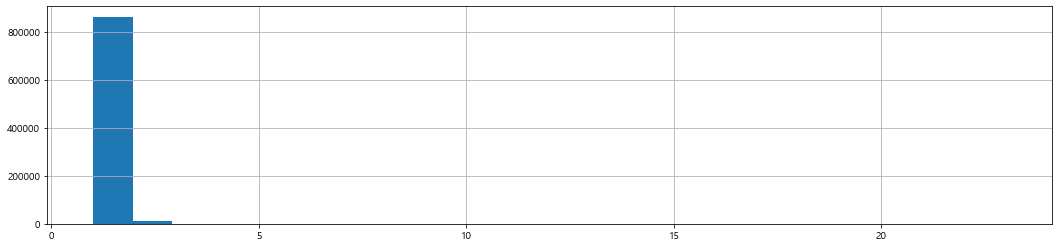

In [329]:
# row별 count값 분포 확인
df['count'].hist(bins = 23)

<AxesSubplot:>

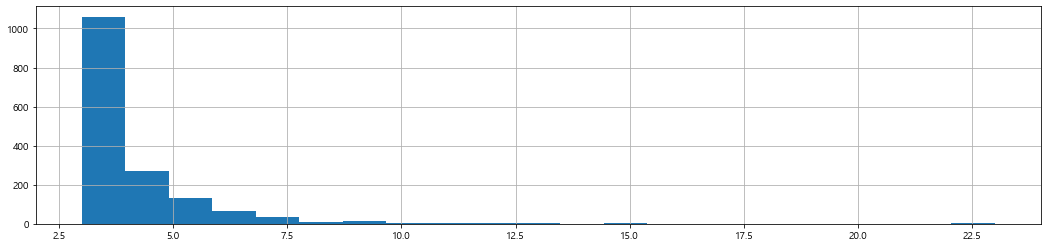

In [330]:
# row별 count값 3회 이상인 건의 분포확인
df[df['count']>2]['count'].hist(bins = 21)

In [331]:
# count가 6건 이상인 경우 이상치로 판단하여 제거하고 진행
df = df[df['count'] <= 5]
df

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,pay_yearmonth,pay_dow
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014-01,2020-01,Wednesday
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014-02,2020-01,Wednesday
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014-11,2020-01,Wednesday
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014-12,2020-01,Wednesday
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014-12,2020-01,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020-12,2020-12,Thursday
879267,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020-12,2020-12,Thursday
879268,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020-12,2020-12,Thursday
879269,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020-12,2020-12,Thursday


⚡<b>인사이트</b>⚡
- 데이터셋의 'count' 컬럼은 같은 날짜에 같은 store를 이용한 건수이므로, 해당 숫자가 너무 높은 건은 이상치로 판단해도 될 것으로 보임
- 시스템 오류 및 기타 사유로 같은날 같은 store에서 여러 건의 결제가 발생했을 가능성도 배제할 수 없음
- 유저가 한달에 얼마나 자주 서비스를 이용하는지 예측하는데 있어 오히려 정확도를 떨어뜨릴 가능성이 있음

In [332]:
# 유저별 전체 사용횟수
df_user = df.groupby('user_id')['count'].sum().reset_index().sort_values(by = 'count', ascending = False)
df_user

,user_id,count
16445,591610,245
76224,1355841,235
62803,1224426,223
77194,1365069,222
82056,1407916,222
...,...,...
45664,1023952,1
110146,1551310,1
110145,1551304,1
45665,1023966,1


<AxesSubplot:>

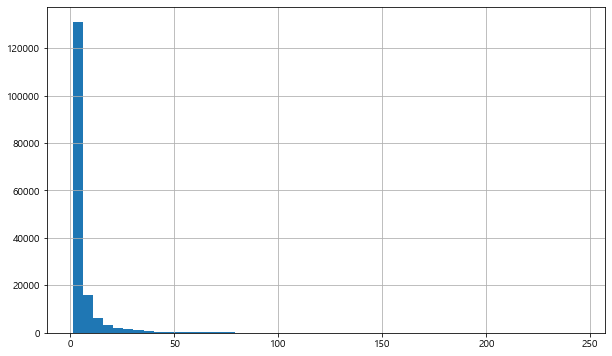

In [333]:
df_user['count'].hist(bins = 50, figsize=(10,6))

In [334]:
df_user[df_user['count']==1]

,user_id,count
15345,571072,1
28056,772460,1
128403,1626016,1
128404,1626021,1
127860,1623807,1
...,...,...
45664,1023952,1
110146,1551310,1
110145,1551304,1
45665,1023966,1


In [335]:
# 전체 유저의 44.7%는 사용 이력이 1회
round(len(df_user.loc[df_user['count']==1, 'user_id'].to_list()) / df_user.shape[0] * 100,1)

44.7

⚡<b>인사이트</b>⚡
- 어떤 특성을 가진 유저가 서비스를 더 많이 이용하는지를 구분하고자 하는 문제이므로, 주어진 기간중 사용이력이 1회인 유저 정보는 제외한 데이터셋으로도 예측 모델을 돌려 성능을 비교할 필요가 있음

## join_date(가입일) 기준

In [336]:
# 가입일이 1970-01-01인 데이터 1093건
df_join_date = df.groupby('join_date')['count'].agg(['count','sum']).reset_index()
df_join_date

,join_date,count,sum
0,1970-01-01,1093,1119
1,2013-12-16,2,2
2,2013-12-17,26,27
3,2013-12-18,1,1
4,2013-12-21,2,2
...,...,...,...
2347,2020-12-27,102,105
2348,2020-12-28,135,140
2349,2020-12-29,115,117
2350,2020-12-30,106,108


In [337]:
# user_id가 join_date 순서로 부여되었는지 확인
df_join_order = df.groupby('user_id')['join_date', 'count'].agg({'join_date' : 'min',
                                                                 'count' : 'sum'}).reset_index().sort_values(by = 'user_id')
df_join_order

<ipython-input-337-822f6a27cb88>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_join_order = df.groupby('user_id')['join_date', 'count'].agg({'join_date' : 'min',


,user_id,join_date,count
0,224,2013-12-16,2
1,232,2013-12-17,24
2,342,2013-12-17,1
3,565,2013-12-17,2
4,729,2013-12-18,1
...,...,...,...
165402,1830551,2020-12-31,1
165403,1830570,2020-12-31,1
165404,1830580,2020-12-31,1
165405,1830589,2020-12-31,1


In [338]:
# user_id는 join_date 순으로 부여되었음 (user_id가 작을수록 먼저 가입한 유저)
# join_date이 1970-01-01로 들어가있는 경우는 직전 유저 가입일로 임의 대체
check_1970 = 0
check_others = 0

for i in range(0, df_join_order.shape[0]):
    try:
        if (df_join_order.loc[i,'join_date'] - df_join_order.loc[i+1, 'join_date']).days > 0:
            if str(df_join_order.loc[i+1, 'join_date'] == '1970-01-01 00:00:00'):
                check_1970 += 1
                df_join_order.loc[i+1, 'join_date'] = df_join_order.loc[i,'join_date']
                
            else:
                check_others += 1
    except:
        pass

check_1970, check_others

(264, 0)

In [339]:
# 대체완료 확인
df_join_order[df_join_order['join_date']=='1970-01-01']

,user_id,join_date,count


In [340]:
df_join_order['join_yearmonth'] = df_join_order['join_date'].dt.strftime('%Y-%m')
df_join_order

,user_id,join_date,count,join_yearmonth
0,224,2013-12-16,2,2013-12
1,232,2013-12-17,24,2013-12
2,342,2013-12-17,1,2013-12
3,565,2013-12-17,2,2013-12
4,729,2013-12-18,1,2013-12
...,...,...,...,...
165402,1830551,2020-12-31,1,2020-12
165403,1830570,2020-12-31,1,2020-12
165404,1830580,2020-12-31,1,2020-12
165405,1830589,2020-12-31,1,2020-12


In [341]:
df_join_date = df_join_order.groupby('join_yearmonth')['user_id','count'].agg(
    {'user_id' : 'count', 'count' : 'sum'}).reset_index().sort_values(by = 'join_yearmonth')
df_join_date

<ipython-input-341-9239d7eac0c8>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_join_date = df_join_order.groupby('join_yearmonth')['user_id','count'].agg(


,join_yearmonth,user_id,count
0,2013-12,9,38
1,2014-01,14,113
2,2014-02,9,33
3,2014-03,10,121
4,2014-04,1,5
...,...,...,...
80,2020-08,7126,30683
81,2020-09,6486,25659
82,2020-10,7582,20961
83,2020-11,7007,15623


<AxesSubplot:xlabel='join_yearmonth', ylabel='count'>

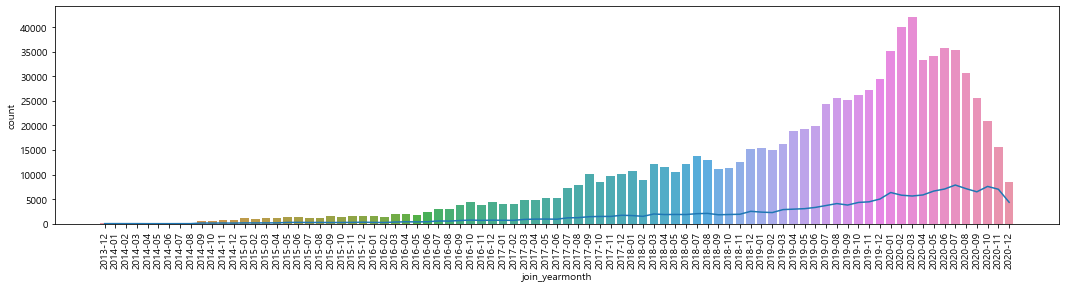

In [342]:
# 가입연월별 2020년 총 이용건수 및 유저수
# 2013년 -> 2020년으로 갈수록 유저 수가 증가하여 이용건수가 증가한 것으로 보임
plt.figure(figsize = (18,4))
plt.xticks(rotation = 90)
sns.barplot(x = df_join_date['join_yearmonth'], y = df_join_date['count'])
sns.lineplot(x = df_join_date['join_yearmonth'], y = df_join_date['user_id'])

In [343]:
# 가입연월별 2020년 인당 이용건수 비교
df_per_person = df_join_order.groupby('join_yearmonth')['count'].mean().reset_index()
df_per_person

,join_yearmonth,count
0,2013-12,4.222222
1,2014-01,8.071429
2,2014-02,3.666667
3,2014-03,12.100000
4,2014-04,5.000000
...,...,...
80,2020-08,4.305782
81,2020-09,3.956059
82,2020-10,2.764574
83,2020-11,2.229628


<AxesSubplot:xlabel='join_yearmonth', ylabel='count'>

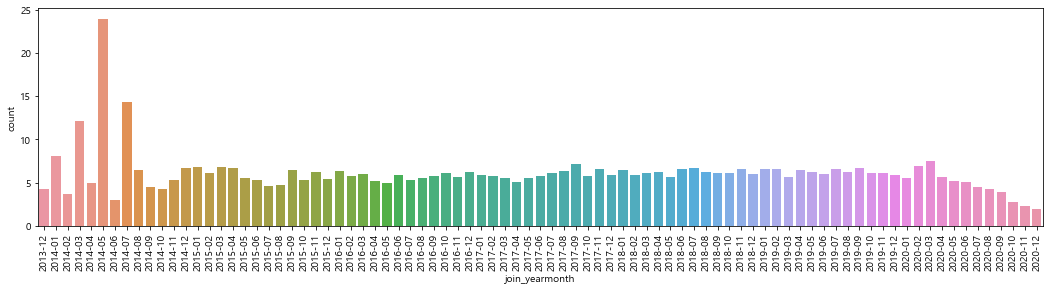

In [344]:
# 가입연월별 2020년 인당 이용건수는 5~10건 범위에서 대체로 비슷하게 나타남
# 2014년 가입한 유저들 중 heavy user들이 있을 것으로 보이나 전체적으로 가입연월에 따른 이용횟수의 차이는 없는 것으로 보임
plt.figure(figsize = (18,4))
plt.xticks(rotation = 90)
sns.barplot(x = df_per_person['join_yearmonth'], y = df_per_person['count'])

⚡<b>인사이트</b>⚡
- join_date는 유저의 서비스 이용횟수 예측에 중요한 정보가 아닌 것으로 보임

## date(사용일) 기준

In [345]:
df_date = df.groupby('date')['count', 'pay_yearmonth'].agg({
    'count' : 'sum', 'pay_yearmonth' : 'max'}).reset_index()
df_date

<ipython-input-345-ba4d8eac5e68>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_date = df.groupby('date')['count', 'pay_yearmonth'].agg({


,date,count,pay_yearmonth
0,2020-01-01,929,2020-01
1,2020-01-02,1507,2020-01
2,2020-01-03,1751,2020-01
3,2020-01-04,2217,2020-01
4,2020-01-05,1517,2020-01
...,...,...,...
361,2020-12-27,1292,2020-12
362,2020-12-28,2773,2020-12
363,2020-12-29,2797,2020-12
364,2020-12-30,2879,2020-12


<AxesSubplot:xlabel='pay_yearmonth', ylabel='count'>

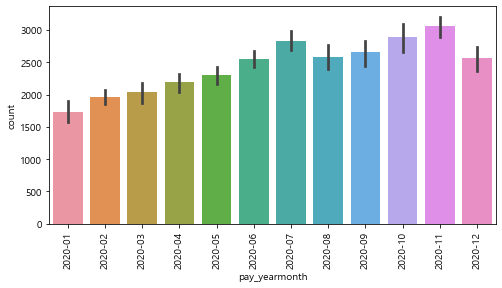

In [346]:
# 2020년 이용건수 분포
# 2020년에는 지속적으로 이용건수가 증가하는 추세에서 8,9,12월은 감소하였음
plt.figure(figsize = (8,4))
plt.xticks(rotation = 90)
sns.barplot(x = df_date['pay_yearmonth'], y = df_date['count'])

In [347]:
# 요일별 이용건수 분포
df_dow = df.groupby('pay_dow')['count'].sum().reset_index().sort_values(by = 'count', ascending = False)
df_dow

,pay_dow,count
0,Friday,140488
4,Thursday,136036
6,Wednesday,134737
2,Saturday,134188
5,Tuesday,133104
1,Monday,129347
3,Sunday,87842


<AxesSubplot:xlabel='pay_dow', ylabel='count'>

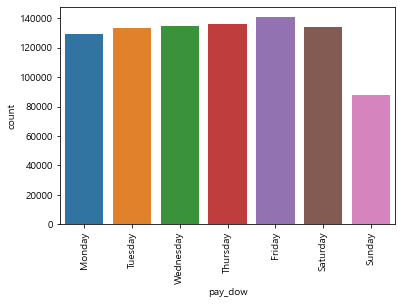

In [348]:
# 요일별 이용자수 : 목~금요일이 가장 많으며, 일요일이 가장 적음
plt.figure(figsize = (6,4))
plt.xticks(rotation = 90)
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.barplot(x = df_dow['pay_dow'], y = df_dow['count'], order = dow_order)

⚡<b>인사이트</b>⚡
- 주어진 데이터셋이 1년치이므로 모델 예측에 월 정보를 활용하기는 어려우나, 요일 정보는 피쳐로 활용 가능할 것으로 보임

## store_id 기준

### Store별 이용건수

In [349]:
# 총 1060개의 store_id
df_store_id = df.groupby('store_id')['count'].agg('sum').reset_index().sort_values(by = 'count',ascending = False)
df_store_id

,store_id,count
513,220557,17772
611,220893,17510
532,220655,16775
142,92437,16300
602,220848,16263
...,...,...
930,230196,1
926,230190,1
463,220018,1
922,228955,1


In [350]:
# store_id별, user_id별 이용건수 확인
df_store_user = df.groupby(['store_id', 'user_id'])['count'].agg('sum').reset_index().sort_values(by = ['count'],ascending = False).head(30)
df_store_user.sort_values(by = 'count',ascending = False)

,store_id,user_id,count
146232,109557,1355841,235
146245,109557,1365069,222
238709,220655,1144500,213
146180,109557,1284291,210
180778,182296,909315,209
498,472,1201981,207
45882,82433,1318771,199
88191,92437,571472,196
146223,109557,1342970,194
144613,109555,1419336,193


<AxesSubplot:>

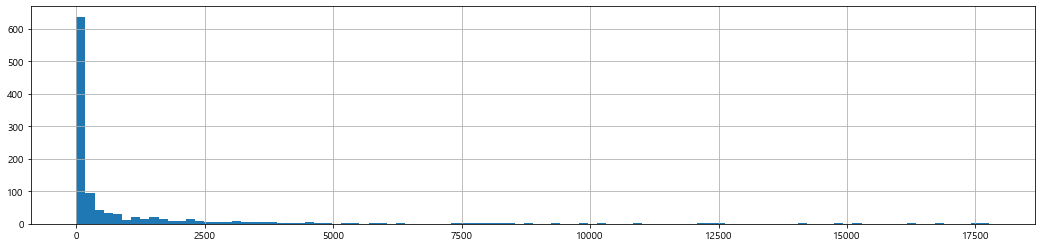

In [351]:
# 이용건수 분포 확인
df_store_id['count'].hist(bins = 100)

In [352]:
# 전체 store_id의 5.9%는 이용건수가 1건이며, 전체적으로 store_id별 이용건수의 편차가 크게 나타남
round(df_store_id[df_store_id['count'] == 1].shape[0] / df_store_id.shape[0] * 100, 2)

5.94

### 유저별 이용한 Store 개수

In [353]:
# 한 유저가 최대 244개 store까지 이용하였음
df_user_store = df.groupby('user_id')['store_id', 'count'].agg({
    'store_id' : 'count', 'count' : 'sum'}).reset_index().sort_values(by = 'store_id', ascending = False)
df_user_store

<ipython-input-353-749023c4260e>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_user_store = df.groupby('user_id')['store_id', 'count'].agg({


,user_id,store_id,count
16445,591610,244,245
76224,1355841,235,235
82056,1407916,222,222
62803,1224426,222,223
77194,1365069,222,222
...,...,...,...
45030,1014853,1,1
109620,1549211,1,1
109619,1549210,1,1
45032,1014878,1,1


<AxesSubplot:>

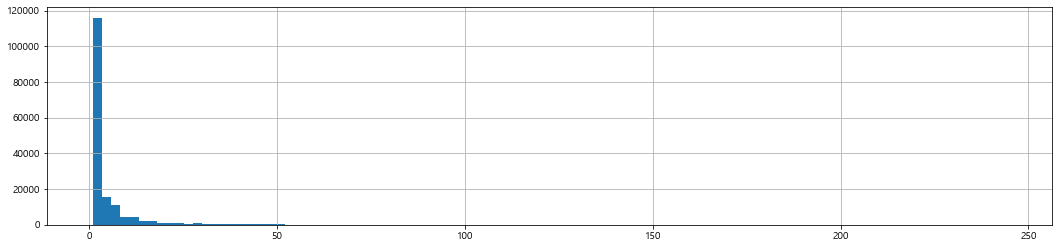

In [354]:
# 유저별 이용한 store 개수 분포 확인
df_user_store['store_id'].hist(bins = 100)

In [355]:
# 전체 유저의 45.3%는 1개 store만 이용하였음
round(df_user_store[df_user_store['store_id'] == 1].shape[0] / df_user_store.shape[0] * 100, 1)

45.3

In [356]:
# 서비스 이용횟수가 높은 유저들은 같은 store를 이용하는 경우가 많은 것으로 보임
df_store_id_user = df.groupby(['store_id','user_id'])['count'].sum().reset_index().sort_values(by = 'count', ascending = False)
df_store_id_user

,store_id,user_id,count
146232,109557,1355841,235
146245,109557,1365069,222
238709,220655,1144500,213
146180,109557,1284291,210
180778,182296,909315,209
...,...,...,...
123448,106076,1588439,1
123450,106076,1593121,1
123451,106076,1594464,1
123452,106076,1595065,1


<AxesSubplot:>

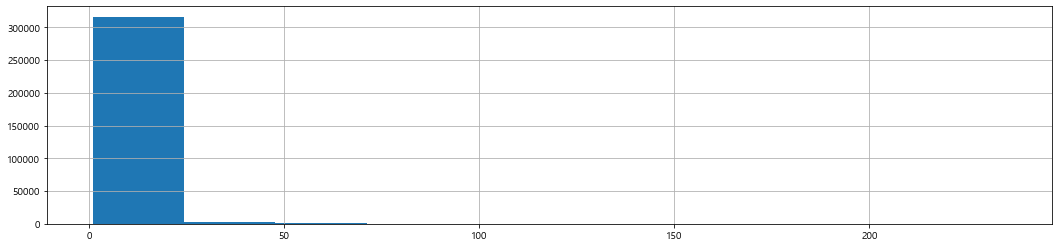

In [357]:
df_store_id_user['count'].hist()

⚡<b>인사이트</b>⚡
- 이용횟수가 많은 유저들은 같은 store 서비스를 이용하는 경향이 있는 것으로 보이며, 이는 주 생활 반경이 어느정도 정해져있는 이유도 있겠지만 해당 store의 편의성이 좋기 때문일 가능성도 있음
- store_id는 피쳐로 활용 가능할 것으로 보임

## dtype 기준

In [358]:
df_dtype = df.groupby('d_type')['count'].sum().reset_index()
df_dtype

,d_type,count
0,AA,503202
1,BB,391296
2,CC,1244


<AxesSubplot:xlabel='d_type', ylabel='count'>

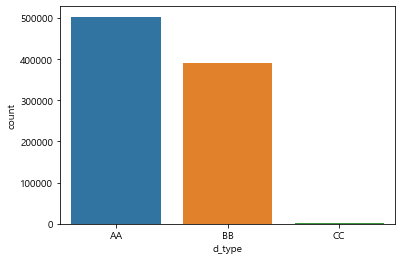

In [359]:
# AA 타입이 가장 높은 비율을 차지
plt.figure(figsize = (6,4))
sns.barplot(x = df_dtype['d_type'], y = df_dtype['count'])

⚡<b>인사이트</b>⚡
- 모두의주차장 서비스 이용 옵션들을 확인한 결과 d_type은 결제수단을 의미하는 컬럼일 것으로 추정<br>
AA: 카드결제<br>
BB: 네이버페이<br>
CC: 휴대폰결제<br>
- d_type은 피쳐로 활용 가능할 것으로 보임

## goods_type 기준

In [360]:
df_goods = df.groupby('goods_type')['count'].sum().reset_index()
df_goods

,goods_type,count
0,A,620834
1,B,120103
2,C,134550
3,D,20255


<AxesSubplot:xlabel='goods_type', ylabel='count'>

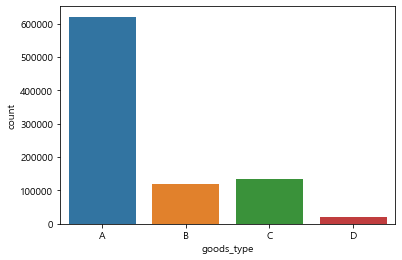

In [361]:
# A 타입이 가장 높은 비율을 차지
plt.figure(figsize = (6,4))
sns.barplot(x = df_goods['goods_type'], y = df_goods['count'])

⚡<b>인사이트</b>⚡
- 모두의주차장 서비스 이용 옵션들을 확인한 결과 goods_type은 티켓타입을 의미하는 컬럼일 것으로 추정
- 당일권, 3시간권, 2시간권, 1시간권 등의 다양한 옵션이 있고 평일과 휴일의 티켓이 구분되어 있으므로 A~D가 각각 어떤 티켓타입인지는 확정하기 어려움
- goods_type은 피쳐로 활용 가능할 것으로 보임

## ad1 기준

In [362]:
df_ad1 = df.groupby('ad1')['count'].sum().reset_index().sort_values(by = 'count', ascending = False)
df_ad1

,ad1,count
49,J,182583
39,GN,176529
51,JRR,129219
63,SC,77137
52,MP,68854
...,...,...
70,SP,3
71,VO,1
54,NW,1
41,GR,1


<AxesSubplot:xlabel='ad1', ylabel='count'>

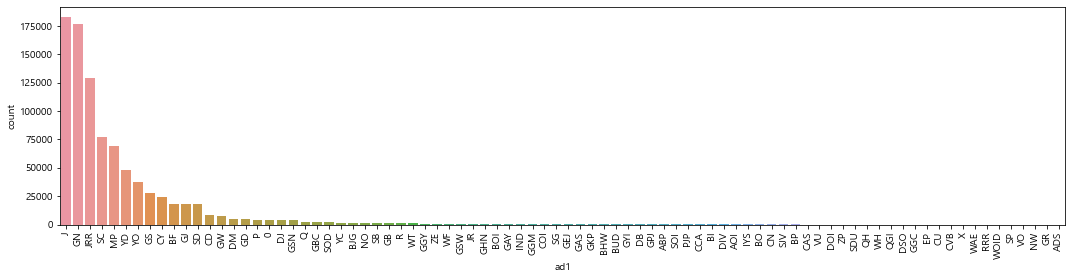

In [363]:
# J, GN이 전체 이용건수 기준 가장 높은 비율을 차지
plt.figure(figsize = (18,4))
plt.xticks(rotation = 90)
sns.barplot(x = df_ad1['ad1'], y = df_ad1['count'])

In [364]:
# 서비스 이용횟수가 높은 유저들은 같은 ad1에서 사용하는 경우가 많은 것으로 보임
df_ad1_user = df.groupby(['ad1','user_id'])['count'].sum().reset_index().sort_values(by = 'count', ascending = False)
df_ad1_user

,ad1,user_id,count
134862,JRR,591610,245
30102,GJ,1355841,235
30144,GJ,1365069,222
145433,JRR,1144500,213
29798,GJ,1284291,210
...,...,...,...
105510,J,1142320,1
105511,J,1142365,1
105513,J,1142635,1
105515,J,1142740,1


⚡<b>인사이트</b>⚡
- ad1은 주차장 위치에 대한 지역 표기일 것으로 추정됨
- 이용횟수가 많은 유저들은 같은 ad1에서 서비스를 이용하는 경향이 있는 것으로 보이며, 이는 주 생활 반경이 어느정도 정해져있는 이유도 있겠지만 해당 ad1의 주차장 개수, 편의성 등의 인프라가 좋기 때문일 가능성도 있음
- ad1은 피쳐로 활용 가능할 것으로 보임

# 심층 EDA


## top users
- 결제건수 상위 20명 유저를 대상으로 컬럼별 특징 살펴보기

In [365]:
df_user

,user_id,count
16445,591610,245
76224,1355841,235
62803,1224426,223
77194,1365069,222
82056,1407916,222
...,...,...
45664,1023952,1
110146,1551310,1
110145,1551304,1
45665,1023966,1


In [366]:
# 결제건수 상위 20명 유저
top_users_list = df_user['user_id'].head(20).unique()
top_users_list

array([ 591610, 1355841, 1224426, 1365069, 1407916, 1284291, 1144500,
        909315, 1504815, 1201981,  571472, 1532535,  612237,  640247,
       1318771,  603013, 1303371,  812843, 1506306, 1419336], dtype=int64)

In [367]:
top_users = df[df['user_id'].isin(top_users_list)].sort_values(by = 'user_id').reset_index()
top_users

,index,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,pay_yearmonth,pay_dow
0,415499,571472,2017-08-03,AA,92437,B,2020-07-14,1,J,2017-08,2020-07,Tuesday
1,551000,571472,2017-08-03,AA,92437,B,2020-09-03,1,J,2017-08,2020-09,Thursday
2,553682,571472,2017-08-03,AA,92437,B,2020-09-04,1,J,2017-08,2020-09,Friday
3,249458,571472,2017-08-03,AA,92437,B,2020-05-08,1,J,2017-08,2020-05,Friday
4,247164,571472,2017-08-03,AA,92437,B,2020-05-07,1,J,2017-08,2020-05,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...
4071,530403,1532535,2020-03-31,BB,219913,B,2020-08-25,1,GN,2020-03,2020-08,Tuesday
4072,533134,1532535,2020-03-31,BB,219913,B,2020-08-26,1,GN,2020-03,2020-08,Wednesday
4073,535880,1532535,2020-03-31,BB,219913,B,2020-08-27,1,GN,2020-03,2020-08,Thursday
4074,521644,1532535,2020-03-31,BB,219913,B,2020-08-21,1,GN,2020-03,2020-08,Friday


In [368]:
# dtype : 각 유저당 하나의 dtype을 가짐
# 결제수단일 것으로 추정됨
for user in top_users_list:
  df_top = top_users.copy()
  d_type = df_top[df_top['user_id'] == user]['d_type'].unique()
  print(d_type)

['AA']
['AA']
['BB']
['AA']
['AA']
['AA']
['AA']
['BB']
['AA']
['BB']
['AA']
['BB']
['AA']
['BB']
['AA']
['AA']
['AA']
['AA']
['AA']
['BB']


In [369]:
# goods_type : 유저마다 다양한 goods_type 정보를 가짐
# 구매한 티켓 종류일 것으로 추정됨 (1일권, 3시간권 등)
for user in top_users_list:
  df_top = top_users.copy()
  inputs = df_top[df_top['user_id'] == user]['goods_type'].unique()
  print(inputs)

['A' 'C']
['A']
['A' 'B']
['A']
['A' 'D' 'B' 'C']
['A' 'C' 'B']
['A']
['A']
['A']
['A']
['B' 'A' 'C']
['B' 'A']
['A']
['A' 'C']
['A' 'D']
['A' 'B']
['A' 'D']
['C' 'A']
['A']
['B' 'C' 'D' 'A']


In [370]:
# ad1 : 유저마다 다양한 ad1 정보를 가짐
# 지역 분류일 것으로 추정됨
for user in top_users_list:
  df_top = top_users.copy()
  inputs = df_top[df_top['user_id'] == user]['ad1'].unique()
  print(inputs)

['JRR']
['GJ']
['J' 'YO']
['GJ']
['J' 'JRR']
['GJ' 'JRR' 'MP']
['JRR']
['SC']
['GN']
['GN']
['J' 'JRR' 'SD']
['GN']
['MP']
['CY']
['CY']
['JRR']
['JRR']
['GN' 'J']
['GS']
['GJ' 'J']


## top stores
- 결제건수 상위 20개 store 대상으로 컬럼별 특징 살펴보기

In [371]:
# 결제건수 상위 20개 store
top_stores_list = df.groupby('store_id')['count'].sum().sort_values(ascending = False).reset_index().head(20)['store_id'].tolist()
top_stores_list

[220557,
 220893,
 220655,
 92437,
 220848,
 105033,
 91853,
 1109,
 82400,
 109037,
 173268,
 220836,
 220745,
 220897,
 182296,
 221045,
 28018,
 109557,
 90542,
 109400]

In [372]:
top_stores = df[df['store_id'].isin(top_stores_list)].sort_values(by = 'store_id').reset_index()
top_stores

,index,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,pay_yearmonth,pay_dow
0,212738,790773,2018-04-28,AA,1109,A,2020-04-21,1,JRR,2018-04,2020-04,Tuesday
1,778555,1646920,2020-08-04,BB,1109,A,2020-11-22,1,JRR,2020-08,2020-11,Sunday
2,71090,1398716,2019-11-19,BB,1109,A,2020-02-10,1,JRR,2019-11,2020-02,Monday
3,71078,1395886,2019-11-17,BB,1109,A,2020-02-10,1,JRR,2019-11,2020-02,Monday
4,226380,615723,2017-09-30,AA,1109,A,2020-04-27,1,JRR,2017-09,2020-04,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...
246394,683770,1158885,2019-05-09,AA,221045,A,2020-10-23,1,GN,2019-05,2020-10,Friday
246395,657637,1675763,2020-09-02,BB,221045,A,2020-10-14,1,GN,2020-09,2020-10,Wednesday
246396,538856,1572694,2020-05-19,AA,221045,A,2020-08-28,1,GN,2020-05,2020-08,Friday
246397,784728,1715900,2020-10-05,AA,221045,A,2020-11-24,1,GN,2020-10,2020-11,Tuesday


In [373]:
# dtype : 스토어마다 다양한 d_type 정보를 가짐
for store in top_stores_list:
  df_top = top_stores.copy()
  d_type = df_top[df_top['store_id'] == store]['d_type'].unique()
  print(d_type)

['AA' 'BB' 'CC']
['AA' 'BB' 'CC']
['AA' 'BB' 'CC']
['AA' 'BB' 'CC']
['BB' 'AA' 'CC']
['BB' 'AA' 'CC']
['BB' 'AA' 'CC']
['AA' 'BB' 'CC']
['AA' 'BB' 'CC']
['AA' 'BB' 'CC']
['AA' 'BB' 'CC']
['BB' 'AA' 'CC']
['AA' 'BB' 'CC']
['AA' 'BB' 'CC']
['AA' 'BB' 'CC']
['AA' 'BB' 'CC']
['BB' 'AA' 'CC']
['AA' 'BB' 'CC']
['BB' 'AA' 'CC']
['AA' 'BB']


In [374]:
# goods_type : 스토어마다 다양한 goods_type 정보를 가짐
for store in top_stores_list:
  df_top = top_stores.copy()
  goods_type = df_top[df_top['store_id'] == store]['goods_type'].unique()
  print(goods_type)

['A' 'D']
['A' 'B' 'C']
['A' 'B']
['C' 'A' 'B']
['C' 'B']
['A' 'B']
['A' 'D' 'B']
['A' 'D']
['A' 'B']
['A' 'B' 'D']
['A' 'D' 'B']
['A' 'B']
['B' 'A']
['B' 'A']
['A' 'B']
['A' 'B']
['C' 'B']
['A' 'B']
['A' 'B' 'D']
['C' 'B' 'A']


In [375]:
# ad1 : 각 스토어당 하나의 ad1 정보를 가짐
for store in top_stores_list:
  df_top = top_stores.copy()
  ad1 = df_top[df_top['store_id'] == store]['ad1'].unique()
  print(ad1)

['YO']
['J']
['JRR']
['J']
['GN']
['SC']
['YD']
['JRR']
['JRR']
['J']
['J']
['JRR']
['SD']
['J']
['SC']
['GN']
['JRR']
['GJ']
['GN']
['J']


⚡<b>인사이트</b>⚡
- 유저마다 하나의 d_type이 매칭되고, 스토어마다 하나의 ad1이 매칭됨
- d_type은 결제수단, ad1은 지역일 것이라는 가설 확인

# 외부 데이터 활용

## 기상 데이터

In [376]:
# 기상정보 데이터셋 불러오기
climate = pd.read_csv('서울시_기상데이터.csv', encoding = 'cp949')
climate

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
0,108,2020-01-01 1:00,-5.9,NaN,1.7,40,NaN,NaN,-2.4,3.2
1,108,2020-01-01 2:00,-5.7,NaN,0.1,42,NaN,NaN,-2.4,3.1
2,108,2020-01-01 3:00,-5.6,0.0,0.0,46,NaN,NaN,-2.7,3.1
3,108,2020-01-01 4:00,-5.4,NaN,0.0,50,NaN,NaN,-2.5,3.0
4,108,2020-01-01 5:00,-5.2,NaN,0.0,55,NaN,NaN,-2.2,3.0
...,...,...,...,...,...,...,...,...,...,...
8755,108,2020-12-30 20:00,-11.8,NaN,4.8,54,NaN,NaN,-6.5,2.2
8756,108,2020-12-30 21:00,-12.4,NaN,3.2,58,NaN,NaN,-6.9,2.2
8757,108,2020-12-30 22:00,-12.7,NaN,2.8,56,NaN,NaN,-7.1,2.1
8758,108,2020-12-30 23:00,-12.9,NaN,2.2,54,NaN,NaN,-7.3,2.1


In [377]:
climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   지점      8760 non-null   int64  
 1   일시      8760 non-null   object 
 2   기온      8759 non-null   float64
 3   강수량     1059 non-null   float64
 4   풍속      8760 non-null   float64
 5   습도      8760 non-null   int64  
 6   일조시간    4791 non-null   float64
 7   적설량     208 non-null    float64
 8   지면온도    8752 non-null   float64
 9   지중온도    8748 non-null   float64
dtypes: float64(7), int64(2), object(1)
memory usage: 684.5+ KB


In [378]:
# 날짜컬럼 생성
climate['날짜'] = climate['일시'].apply(lambda x : x[:10])
climate

,지점,일시,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도,날짜
0,108,2020-01-01 1:00,-5.9,NaN,1.7,40,NaN,NaN,-2.4,3.2,2020-01-01
1,108,2020-01-01 2:00,-5.7,NaN,0.1,42,NaN,NaN,-2.4,3.1,2020-01-01
2,108,2020-01-01 3:00,-5.6,0.0,0.0,46,NaN,NaN,-2.7,3.1,2020-01-01
3,108,2020-01-01 4:00,-5.4,NaN,0.0,50,NaN,NaN,-2.5,3.0,2020-01-01
4,108,2020-01-01 5:00,-5.2,NaN,0.0,55,NaN,NaN,-2.2,3.0,2020-01-01
...,...,...,...,...,...,...,...,...,...,...,...
8755,108,2020-12-30 20:00,-11.8,NaN,4.8,54,NaN,NaN,-6.5,2.2,2020-12-30
8756,108,2020-12-30 21:00,-12.4,NaN,3.2,58,NaN,NaN,-6.9,2.2,2020-12-30
8757,108,2020-12-30 22:00,-12.7,NaN,2.8,56,NaN,NaN,-7.1,2.1,2020-12-30
8758,108,2020-12-30 23:00,-12.9,NaN,2.2,54,NaN,NaN,-7.3,2.1,2020-12-30


In [379]:
# 날짜별 최저기온, 최고기온, 최대강수량, 최대습도 구하기
climate_grouped = climate.groupby('날짜')['기온','강수량','습도'].agg({'기온':['min','max'],
                                           '강수량':'max',
                                           '습도':'max'})
climate_grouped.columns = [a + '_' + b for a, b in climate_grouped.columns]
climate_grouped

<ipython-input-379-7f313b098779>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  climate_grouped = climate.groupby('날짜')['기온','강수량','습도'].agg({'기온':['min','max'],


,기온_min,기온_max,강수량_max,습도_max
날짜,,,,
2020-01-01,-5.9,0.3,0.1,76
2020-01-02,-0.7,3.8,NaN,74
2020-01-03,-3.3,4.3,NaN,86
2020-01-04,-2.7,6.1,NaN,64
2020-01-05,-3.1,6.5,NaN,61
...,...,...,...,...
2020-12-27,1.4,9.9,0.0,77
2020-12-28,4.3,11.0,1.3,91
2020-12-29,-5.5,4.2,0.2,85


In [380]:
# 강수량 NaN값인 경우 0으로, 강수량 값이 존재하는 경우 1로 대체하여 binary 변수로 활용
climate_grouped.loc[climate_grouped['강수량_max'].isnull(), '강수량_max'] = 0
climate_grouped.loc[climate_grouped['강수량_max'].notnull(), '강수량_max'] = 1
climate_grouped

,기온_min,기온_max,강수량_max,습도_max
날짜,,,,
2020-01-01,-5.9,0.3,1.0,76
2020-01-02,-0.7,3.8,1.0,74
2020-01-03,-3.3,4.3,1.0,86
2020-01-04,-2.7,6.1,1.0,64
2020-01-05,-3.1,6.5,1.0,61
...,...,...,...,...
2020-12-27,1.4,9.9,1.0,77
2020-12-28,4.3,11.0,1.0,91
2020-12-29,-5.5,4.2,1.0,85


In [381]:
climate_merge = climate_grouped.reset_index()
climate_merge.columns = ['date', 'temp_min', 'temp_max', 'rain', 'humidity']
climate_merge['date'] = climate_merge['date'].apply(lambda X : pd.to_datetime(X))
df_merge = df.groupby('date')['count'].agg('sum').reset_index()

df_climate = climate_merge.merge(df_merge, how = 'outer', on = 'date')
df_climate

,date,temp_min,temp_max,rain,humidity,count
0,2020-01-01,-5.9,0.3,1.0,76,929
1,2020-01-02,-0.7,3.8,1.0,74,1507
2,2020-01-03,-3.3,4.3,1.0,86,1751
3,2020-01-04,-2.7,6.1,1.0,64,2217
4,2020-01-05,-3.1,6.5,1.0,61,1517
...,...,...,...,...,...,...
361,2020-12-27,1.4,9.9,1.0,77,1292
362,2020-12-28,4.3,11.0,1.0,91,2773
363,2020-12-29,-5.5,4.2,1.0,85,2797
364,2020-12-30,-12.9,-6.2,1.0,63,2879


<AxesSubplot:title={'center':'기상 변수와의 상관성 분석'}>

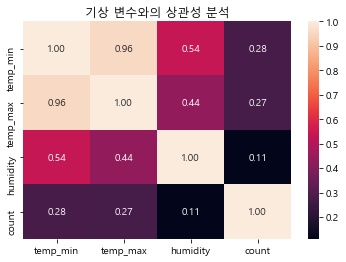

In [382]:
# count 변수와의 상관관계는 temp_min > temp_max > humidity 순
df_climate_heatmap = df_climate[['temp_min', 'temp_max', 'humidity', 'count']]

plt.figure(figsize=(6, 4))
plt.title('기상 변수와의 상관성 분석')
sns.heatmap(df_climate_heatmap.corr(), annot=True, fmt='.2f')

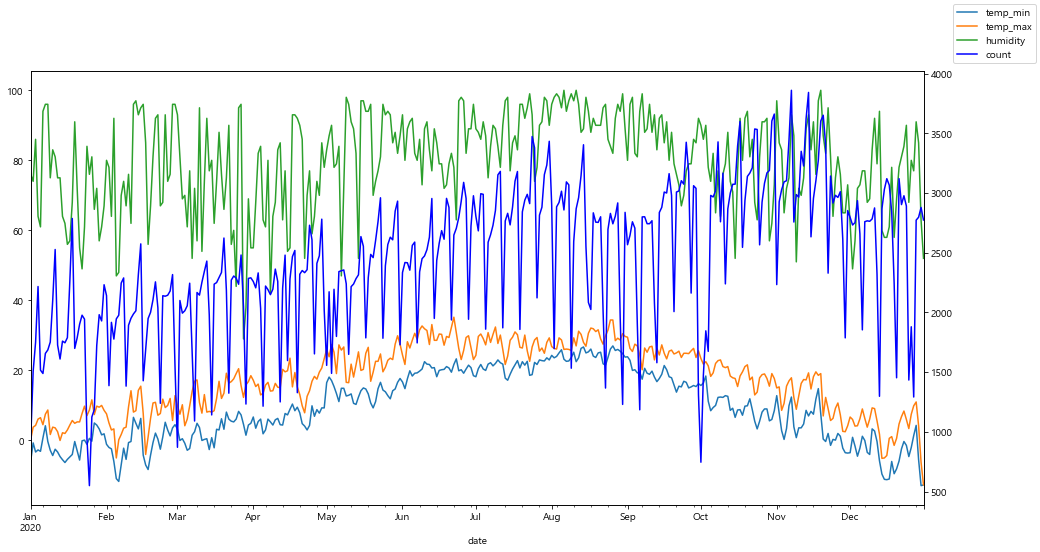

In [383]:
ax = df_climate.plot(x="date", y=['temp_min', 'temp_max', 'humidity'], legend=False, figsize=(16,8))
ax2 = ax.twinx()
df_climate.plot(x="date", y="count", ax=ax2, legend=False, color="b")
ax.figure.legend()
plt.show()

In [384]:
# df 데이터셋에 기상 관련 변수 추가
df = df.merge(df_climate, how = 'outer', on = 'date').drop('count_y', axis = 1).rename(columns = {'count_x' : 'count'})
df

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,pay_yearmonth,pay_dow,temp_min,temp_max,rain,humidity
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014-01,2020-01,Wednesday,-5.9,0.3,1.0,76
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014-02,2020-01,Wednesday,-5.9,0.3,1.0,76
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014-11,2020-01,Wednesday,-5.9,0.3,1.0,76
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014-12,2020-01,Wednesday,-5.9,0.3,1.0,76
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014-12,2020-01,Wednesday,-5.9,0.3,1.0,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878753,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020-12,2020-12,Thursday,-12.7,-12.7,1.0,52
878754,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020-12,2020-12,Thursday,-12.7,-12.7,1.0,52
878755,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020-12,2020-12,Thursday,-12.7,-12.7,1.0,52
878756,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020-12,2020-12,Thursday,-12.7,-12.7,1.0,52


## 교통량 데이터

In [385]:
# 기상정보 데이터셋 불러오기
traffic = pd.read_excel('2020교통량통합.xlsx')
traffic

,DATE,지점명,지점번호,방향,구분,0시,1시,2시,3시,4시,...,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시
0,2020-01-01,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,712.0,645.0,437.0,309.0,290.0,...,1472.0,1416.0,1483.0,1329.0,1157.0,1014.0,954.0,849.0,780.0,480.0
1,2020-01-02,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,315.0,222.0,186.0,165.0,266.0,...,1792.0,1897.0,1842.0,2061.0,1994.0,1443.0,1233.0,1165.0,1094.0,852.0
2,2020-01-03,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,632.0,457.0,295.0,236.0,279.0,...,2004.0,1929.0,2049.0,2140.0,2178.0,1654.0,1356.0,1260.0,1253.0,941.0
3,2020-01-04,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,740.0,518.0,388.0,331.0,330.0,...,1837.0,1788.0,1588.0,1669.0,1530.0,1222.0,1143.0,1089.0,1039.0,791.0
4,2020-01-05,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,533.0,424.0,297.0,230.0,209.0,...,1634.0,1673.0,1494.0,1429.0,1288.0,1035.0,987.0,884.0,803.0,564.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98815,2020-12-27,서부간선도로,F-09,유출,목동교->신정교,1310.0,804.0,582.0,473.0,488.0,...,3026.0,2957.0,2799.0,2858.0,2805.0,3031.0,3173.0,2928.0,2278.0,1559.0
98816,2020-12-28,서부간선도로,F-09,유출,목동교->신정교,1030.0,614.0,501.0,565.0,1160.0,...,2925.0,2595.0,2705.0,2264.0,2272.0,2954.0,3081.0,3099.0,2521.0,1837.0
98817,2020-12-29,서부간선도로,F-09,유출,목동교->신정교,1294.0,833.0,582.0,597.0,900.0,...,2634.0,2851.0,2704.0,2163.0,2165.0,2738.0,3054.0,3078.0,2544.0,1952.0
98818,2020-12-30,서부간선도로,F-09,유출,목동교->신정교,1451.0,929.0,616.0,591.0,929.0,...,2901.0,2636.0,2175.0,2036.0,1969.0,2787.0,3058.0,2936.0,2730.0,2160.0


In [386]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98820 entries, 0 to 98819
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    98820 non-null  datetime64[ns]
 1   지점명     98820 non-null  object        
 2   지점번호    98820 non-null  object        
 3   방향      98820 non-null  object        
 4   구분      98820 non-null  object        
 5   0시      91985 non-null  float64       
 6   1시      91962 non-null  float64       
 7   2시      91960 non-null  float64       
 8   3시      91979 non-null  float64       
 9   4시      91999 non-null  float64       
 10  5시      92036 non-null  float64       
 11  6시      92079 non-null  float64       
 12  7시      92095 non-null  float64       
 13  8시      92081 non-null  float64       
 14  9시      92110 non-null  float64       
 15  10시     92144 non-null  float64       
 16  11시     92100 non-null  float64       
 17  12시     92067 non-null  float64       
 18  13시   

In [387]:
# 일별 교통량 합계 구하기
traffic['traffic_sum'] = traffic.loc[:,'0시':'23시'].sum(axis = 1)

In [388]:
traffic_grouped = traffic.groupby('DATE')['traffic_sum'].sum().reset_index().rename(columns = {'DATE' : 'date'})
df_traffic = traffic_grouped.merge(df_merge, how = 'outer', on = 'date')
df_traffic

,date,traffic_sum,count
0,2020-01-01,7347299.0,929
1,2020-01-02,9326734.0,1507
2,2020-01-03,9998638.0,1751
3,2020-01-04,9198233.0,2217
4,2020-01-05,7868358.0,1517
...,...,...,...
361,2020-12-27,5606406.0,1292
362,2020-12-28,8389535.0,2773
363,2020-12-29,8523717.0,2797
364,2020-12-30,8455563.0,2879


<AxesSubplot:title={'center':'교통량 변수와의 상관성 분석'}>

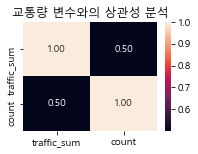

In [389]:
# 교통량과 count 변수와의 상관관계는 0.5로 높은편임
df_traffic_heatmap = df_traffic[['traffic_sum', 'count']]

plt.figure(figsize=(3, 2))
plt.title('교통량 변수와의 상관성 분석')
sns.heatmap(df_traffic_heatmap.corr(), annot=True, fmt='.2f')

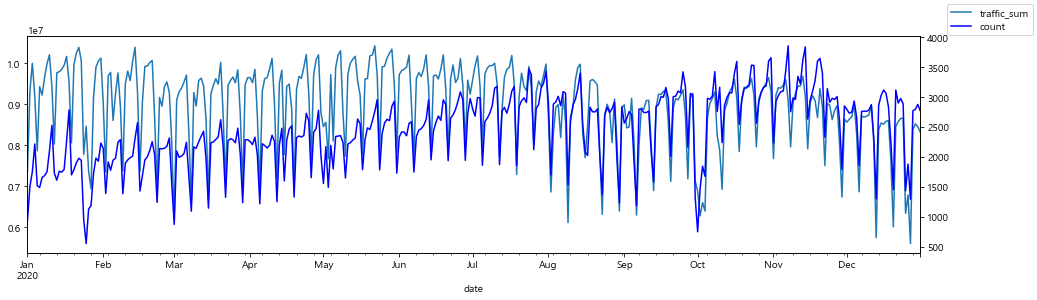

In [390]:
ax = df_traffic.plot(x="date", y='traffic_sum', legend=False, figsize=(16,4))
ax2 = ax.twinx()
df_traffic.plot(x="date", y="count", ax=ax2, legend=False, color="b")
ax.figure.legend()
plt.show()

In [391]:
df_traffic

,date,traffic_sum,count
0,2020-01-01,7347299.0,929
1,2020-01-02,9326734.0,1507
2,2020-01-03,9998638.0,1751
3,2020-01-04,9198233.0,2217
4,2020-01-05,7868358.0,1517
...,...,...,...
361,2020-12-27,5606406.0,1292
362,2020-12-28,8389535.0,2773
363,2020-12-29,8523717.0,2797
364,2020-12-30,8455563.0,2879


In [394]:
# df 데이터셋에 교통량 변수 추가
df = df.merge(df_traffic, how = 'outer', on = 'date').drop('count_y', axis = 1).rename(columns = {'count_x' : 'count'})
df

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,pay_yearmonth,pay_dow,temp_min,temp_max,rain,humidity,traffic_sum
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN,2014-01,2020-01,Wednesday,-5.9,0.3,1.0,76,7347299.0
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J,2014-02,2020-01,Wednesday,-5.9,0.3,1.0,76,7347299.0
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC,2014-11,2020-01,Wednesday,-5.9,0.3,1.0,76,7347299.0
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP,2014-12,2020-01,Wednesday,-5.9,0.3,1.0,76,7347299.0
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR,2014-12,2020-01,Wednesday,-5.9,0.3,1.0,76,7347299.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878753,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020-12,2020-12,Thursday,-12.7,-12.7,1.0,52,8324393.0
878754,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020-12,2020-12,Thursday,-12.7,-12.7,1.0,52,8324393.0
878755,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020-12,2020-12,Thursday,-12.7,-12.7,1.0,52,8324393.0
878756,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020-12,2020-12,Thursday,-12.7,-12.7,1.0,52,8324393.0


# 유저별 특징을 나타내는 컬럼 추가

In [439]:
# 유저, 날짜별 정렬
df_cum = df.sort_values(['user_id','date']).reset_index(drop=True)
df_cum.head()

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,pay_yearmonth,pay_dow,temp_min,temp_max,rain,humidity,traffic_sum
0,224,2013-12-16,AA,92510,A,2020-01-12,1,J,2013-12,2020-01,Sunday,-3.3,2.5,1.0,75,8033315.0
1,224,2013-12-16,AA,181833,C,2020-12-09,1,J,2013-12,2020-12,Wednesday,-4.0,6.1,1.0,69,8710203.0
2,232,2013-12-17,BB,109555,C,2020-01-19,1,GJ,2013-12,2020-01,Sunday,-0.3,4.9,1.0,91,8062593.0
3,232,2013-12-17,BB,28018,C,2020-01-26,1,JRR,2013-12,2020-01,Sunday,-0.2,11.6,1.0,81,7371640.0
4,232,2013-12-17,BB,28018,C,2020-01-27,1,JRR,2013-12,2020-01,Monday,5.0,7.4,1.0,66,6941343.0


In [440]:
# 유저별 각 이용 시점 전의 누적 이용건수 cumsum 컬럼에 추가
df_cum['shifted'] = df_cum.groupby('user_id')['count'].shift()
df_cum['cumsum'] = df_cum.groupby('user_id')['shifted'].cumsum(axis = 0)
df_cum.loc[df_cum['cumsum'].isnull(), 'cumsum'] = 0
df_cum

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,pay_yearmonth,pay_dow,temp_min,temp_max,rain,humidity,traffic_sum,shifted,cumsum
0,224,2013-12-16,AA,92510,A,2020-01-12,1,J,2013-12,2020-01,Sunday,-3.3,2.5,1.0,75,8033315.0,NaN,0.0
1,224,2013-12-16,AA,181833,C,2020-12-09,1,J,2013-12,2020-12,Wednesday,-4.0,6.1,1.0,69,8710203.0,1.0,1.0
2,232,2013-12-17,BB,109555,C,2020-01-19,1,GJ,2013-12,2020-01,Sunday,-0.3,4.9,1.0,91,8062593.0,NaN,0.0
3,232,2013-12-17,BB,28018,C,2020-01-26,1,JRR,2013-12,2020-01,Sunday,-0.2,11.6,1.0,81,7371640.0,1.0,1.0
4,232,2013-12-17,BB,28018,C,2020-01-27,1,JRR,2013-12,2020-01,Monday,5.0,7.4,1.0,66,6941343.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878753,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020-12,2020-12,Thursday,-12.7,-12.7,1.0,52,8324393.0,NaN,0.0
878754,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020-12,2020-12,Thursday,-12.7,-12.7,1.0,52,8324393.0,NaN,0.0
878755,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020-12,2020-12,Thursday,-12.7,-12.7,1.0,52,8324393.0,NaN,0.0
878756,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020-12,2020-12,Thursday,-12.7,-12.7,1.0,52,8324393.0,NaN,0.0


<AxesSubplot:>

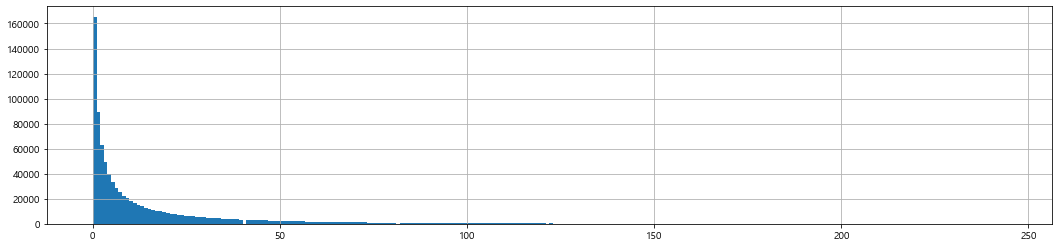

In [441]:
df_cum['cumsum'].hist(bins = 250)

In [457]:
# 누적 이용횟수에 따라 유저 회원등급 부여
# 모델에 컬럼 사용할 때는 각 유저마다 train set의 최종 회원등급을 test set의 데이터에 일괄적으로 부여해야 함

df_cum.loc[df_cum['cumsum'] == 0, 'user_lvl'] = 1    # 첫이용시 회원등급
df_cum.loc[df_cum['cumsum'] == 1, 'user_lvl'] = 2    # 두번째 이용시 회원등급
df_cum.loc[(df_cum['cumsum'] > 1) & (df_cum['cumsum'] <= 10), 'user_lvl'] = 3     # 누적이용 2~10회일 때 회원등급
df_cum.loc[(df_cum['cumsum'] > 10) & (df_cum['cumsum'] <= 50), 'user_lvl'] = 4    # 누적이용 11~50회일 때 회원등급
df_cum.loc[(df_cum['cumsum'] > 50) & (df_cum['cumsum'] <= 100), 'user_lvl'] = 5    # 누적이용 51~100회일 때 회원등급
df_cum.loc[df_cum['cumsum'] > 100, 'user_lvl'] = 6    # 누적이용 100회 이상일 때 회원등급
df_cum

,user_id,join_date,d_type,store_id,goods_type,date,count,ad1,join_yearmonth,pay_yearmonth,pay_dow,temp_min,temp_max,rain,humidity,traffic_sum,shifted,cumsum,user_lvl
0,224,2013-12-16,AA,92510,A,2020-01-12,1,J,2013-12,2020-01,Sunday,-3.3,2.5,1.0,75,8033315.0,NaN,0.0,1.0
1,224,2013-12-16,AA,181833,C,2020-12-09,1,J,2013-12,2020-12,Wednesday,-4.0,6.1,1.0,69,8710203.0,1.0,1.0,2.0
2,232,2013-12-17,BB,109555,C,2020-01-19,1,GJ,2013-12,2020-01,Sunday,-0.3,4.9,1.0,91,8062593.0,NaN,0.0,1.0
3,232,2013-12-17,BB,28018,C,2020-01-26,1,JRR,2013-12,2020-01,Sunday,-0.2,11.6,1.0,81,7371640.0,1.0,1.0,2.0
4,232,2013-12-17,BB,28018,C,2020-01-27,1,JRR,2013-12,2020-01,Monday,5.0,7.4,1.0,66,6941343.0,1.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878753,1830551,2020-12-31,BB,219886,B,2020-12-31,1,GN,2020-12,2020-12,Thursday,-12.7,-12.7,1.0,52,8324393.0,NaN,0.0,1.0
878754,1830570,2020-12-31,BB,82433,B,2020-12-31,1,CY,2020-12,2020-12,Thursday,-12.7,-12.7,1.0,52,8324393.0,NaN,0.0,1.0
878755,1830580,2020-12-31,AA,92020,B,2020-12-31,1,JRR,2020-12,2020-12,Thursday,-12.7,-12.7,1.0,52,8324393.0,NaN,0.0,1.0
878756,1830589,2020-12-31,BB,92437,B,2020-12-31,1,J,2020-12,2020-12,Thursday,-12.7,-12.7,1.0,52,8324393.0,NaN,0.0,1.0


# 모델을 통한 예측 - by rows

## 1회만 결제한 유저

### 제외한 버전

In [ ]:
# # 사용 이력이 1회인 유저 onetime_user_list에 저장 
# onetime_user_list = df_user.loc[df_user['count']==1, 'user_id'].to_list()

In [ ]:
# df_model = df[~df['user_id'].isin(onetime_user_list)]
# df_model

### 제외하지 않은 버전

In [458]:
# df_model 데이터셋 만들고 모델 예측에 필요한 컬럼만 남기기
df_model = df_cum.copy()
df_model = df_model.drop(['join_date', 'store_id', 'join_yearmonth', 'pay_yearmonth', 'shifted', 'cumsum'], axis = 1)
df_model

,user_id,d_type,goods_type,date,count,ad1,pay_dow,temp_min,temp_max,rain,humidity,traffic_sum,user_lvl
0,224,AA,A,2020-01-12,1,J,Sunday,-3.3,2.5,1.0,75,8033315.0,1.0
1,224,AA,C,2020-12-09,1,J,Wednesday,-4.0,6.1,1.0,69,8710203.0,2.0
2,232,BB,C,2020-01-19,1,GJ,Sunday,-0.3,4.9,1.0,91,8062593.0,1.0
3,232,BB,C,2020-01-26,1,JRR,Sunday,-0.2,11.6,1.0,81,7371640.0,2.0
4,232,BB,C,2020-01-27,1,JRR,Monday,5.0,7.4,1.0,66,6941343.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
878753,1830551,BB,B,2020-12-31,1,GN,Thursday,-12.7,-12.7,1.0,52,8324393.0,1.0
878754,1830570,BB,B,2020-12-31,1,CY,Thursday,-12.7,-12.7,1.0,52,8324393.0,1.0
878755,1830580,AA,B,2020-12-31,1,JRR,Thursday,-12.7,-12.7,1.0,52,8324393.0,1.0
878756,1830589,BB,B,2020-12-31,1,J,Thursday,-12.7,-12.7,1.0,52,8324393.0,1.0


In [459]:
# 범주형 변수 컬럼 cat_columns로 구분
cat_columns = [c for c, t in zip(df_model.dtypes.index, df_model.dtypes) if t == 'O'] 
other_columns = [c for c in df_model.columns if c not in cat_columns]

print(f'Categorical Columns: \n{cat_columns}\n\n Other Columns: \n{other_columns}')

Categorical Columns: 
['d_type', 'goods_type', 'ad1', 'pay_dow']

 Other Columns: 
['user_id', 'date', 'count', 'temp_min', 'temp_max', 'rain', 'humidity', 'traffic_sum', 'user_lvl']


## train, test set 나누기

In [460]:
# train set (2020-01 ~ 2020-09)
df_train = df_model[df_model['date'] <= '2020-09-30']
df_train

,user_id,d_type,goods_type,date,count,ad1,pay_dow,temp_min,temp_max,rain,humidity,traffic_sum,user_lvl
0,224,AA,A,2020-01-12,1,J,Sunday,-3.3,2.5,1.0,75,8033315.0,1.0
2,232,BB,C,2020-01-19,1,GJ,Sunday,-0.3,4.9,1.0,91,8062593.0,1.0
3,232,BB,C,2020-01-26,1,JRR,Sunday,-0.2,11.6,1.0,81,7371640.0,2.0
4,232,BB,C,2020-01-27,1,JRR,Monday,5.0,7.4,1.0,66,6941343.0,3.0
5,232,BB,A,2020-01-29,1,YO,Wednesday,3.3,9.5,1.0,57,9906009.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
834652,1709914,BB,B,2020-09-30,1,GN,Wednesday,16.2,25.6,1.0,92,7129682.0,1.0
834667,1709935,AA,B,2020-09-30,1,MP,Wednesday,16.2,25.6,1.0,92,7129682.0,1.0
834668,1709942,AA,B,2020-09-30,1,BF,Wednesday,16.2,25.6,1.0,92,7129682.0,1.0
834669,1709950,BB,A,2020-09-30,2,JRR,Wednesday,16.2,25.6,1.0,92,7129682.0,1.0


In [461]:
# 유저별 train set의 최종 등급 user_lvl에 저장
user_lvl = df_train.groupby('user_id')['user_lvl'].max().reset_index()
user_lvl

,user_id,user_lvl
0,224,1.0
1,232,4.0
2,565,1.0
3,729,1.0
4,1448,2.0
...,...,...
130242,1709914,1.0
130243,1709935,1.0
130244,1709942,1.0
130245,1709950,1.0


In [468]:
# test set (2020-10 ~ 2020-12) 
df_test = df_model[df_model['date'] > '2020-09-30'].drop('user_lvl', axis = 1)
df_test

,user_id,d_type,goods_type,date,count,ad1,pay_dow,temp_min,temp_max,rain,humidity,traffic_sum
1,224,AA,C,2020-12-09,1,J,Wednesday,-4.0,6.1,1.0,69,8710203.0
21,232,BB,B,2020-10-02,1,JRR,Friday,16.4,21.8,1.0,86,6282435.0
22,232,BB,A,2020-10-27,1,J,Tuesday,9.0,19.0,1.0,91,9303245.0
23,232,BB,A,2020-11-16,1,J,Monday,7.5,18.2,1.0,91,9047418.0
24,232,BB,A,2020-11-18,1,J,Wednesday,14.8,18.6,1.0,97,9093256.0
...,...,...,...,...,...,...,...,...,...,...,...,...
878753,1830551,BB,B,2020-12-31,1,GN,Thursday,-12.7,-12.7,1.0,52,8324393.0
878754,1830570,BB,B,2020-12-31,1,CY,Thursday,-12.7,-12.7,1.0,52,8324393.0
878755,1830580,AA,B,2020-12-31,1,JRR,Thursday,-12.7,-12.7,1.0,52,8324393.0
878756,1830589,BB,B,2020-12-31,1,J,Thursday,-12.7,-12.7,1.0,52,8324393.0


In [469]:
# 유저별 train set의 최종등급을 test set의 user_lvl에 업데이트
df_test = df_test.merge(user_lvl, how = 'left', on = 'user_id')
df_test.loc[df_test['user_lvl'].isnull(), 'user_lvl'] = 0
df_test

,user_id,d_type,goods_type,date,count,ad1,pay_dow,temp_min,temp_max,rain,humidity,traffic_sum,user_lvl
0,224,AA,C,2020-12-09,1,J,Wednesday,-4.0,6.1,1.0,69,8710203.0,1.0
1,232,BB,B,2020-10-02,1,JRR,Friday,16.4,21.8,1.0,86,6282435.0,4.0
2,232,BB,A,2020-10-27,1,J,Tuesday,9.0,19.0,1.0,91,9303245.0,4.0
3,232,BB,A,2020-11-16,1,J,Monday,7.5,18.2,1.0,91,9047418.0,4.0
4,232,BB,A,2020-11-18,1,J,Wednesday,14.8,18.6,1.0,97,9093256.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
255529,1830551,BB,B,2020-12-31,1,GN,Thursday,-12.7,-12.7,1.0,52,8324393.0,0.0
255530,1830570,BB,B,2020-12-31,1,CY,Thursday,-12.7,-12.7,1.0,52,8324393.0,0.0
255531,1830580,AA,B,2020-12-31,1,JRR,Thursday,-12.7,-12.7,1.0,52,8324393.0,0.0
255532,1830589,BB,B,2020-12-31,1,J,Thursday,-12.7,-12.7,1.0,52,8324393.0,0.0


In [472]:
# 모델 예측에 불필요한 컬럼 지우기
x_train = df_train.drop(['count', 'date'], axis = 1)
x_test = df_test.drop(['count', 'date'], axis = 1)
y_train = df_train['count']
y_test = df_test['count']

## 전처리 함수

In [473]:
# 원핫인코딩 전처리함수
from sklearn.preprocessing import OneHotEncoder

def onehotencoding(x_train, x_test):
    tmp_x_train = x_train.copy()
    tmp_x_test  = x_test.copy()
    
    # reset index
    tmp_x_train = tmp_x_train.reset_index(drop=True)
    tmp_x_test  = tmp_x_test.reset_index(drop=True)
    
    # cat_columns 원핫인코딩
    ohe = OneHotEncoder(sparse=False)
    x_all = pd.concat([tmp_x_train[cat_columns], 
                       tmp_x_test[cat_columns]], axis=0)

    new_x_all = ohe.fit_transform(x_all)
    
    ohe_columns = []
    for cat in ohe.categories_:
        ohe_columns += cat.tolist()
    
    new_x_all = pd.DataFrame(new_x_all, columns=ohe_columns)

    new_x_train_cat = new_x_all.iloc[:tmp_x_train.shape[0], :]
    new_x_test_cat =  new_x_all.iloc[tmp_x_train.shape[0]:, :]

    new_x_train_cat = new_x_train_cat.reset_index(drop=True)
    new_x_test_cat  = new_x_test_cat.reset_index(drop=True)

    tmp_x_train = tmp_x_train.drop(columns=cat_columns)
    tmp_x_test  = tmp_x_test.drop(columns=cat_columns)

    tmp_x_train = pd.concat([tmp_x_train, new_x_train_cat], axis=1)
    tmp_x_test = pd.concat([tmp_x_test, new_x_test_cat], axis=1)
    
    return tmp_x_train, tmp_x_test

In [474]:
# 라벨인코딩 전처리함수
from sklearn.preprocessing import LabelEncoder

def labelencoding(x_train, x_test):
    tmp_x_train = x_train.copy()
    tmp_x_test  = x_test.copy()
    
    # reset index
    tmp_x_train = tmp_x_train.reset_index(drop=True)
    tmp_x_test  = tmp_x_test.reset_index(drop=True)

    # cat_columns 라벨인코딩
    le = LabelEncoder()
    x_all = pd.concat([tmp_x_train[cat_columns], tmp_x_test[cat_columns]], axis=0)
    new_x_all = x_all.apply(LabelEncoder().fit_transform)
    
    new_x_train_cat = new_x_all.iloc[:tmp_x_train.shape[0], :]
    new_x_test_cat =  new_x_all.iloc[tmp_x_train.shape[0]:, :]

    new_x_train_cat = new_x_train_cat.reset_index(drop=True)
    new_x_test_cat  = new_x_test_cat.reset_index(drop=True)

    tmp_x_train = tmp_x_train.drop(columns=cat_columns)
    tmp_x_test  = tmp_x_test.drop(columns=cat_columns)

    tmp_x_train = pd.concat([tmp_x_train, new_x_train_cat], axis=1)
    tmp_x_test = pd.concat([tmp_x_test, new_x_test_cat], axis=1)
    
    return tmp_x_train, tmp_x_test

In [475]:
# 범주형 변수 라벨인코딩 진행
x_train, x_test = labelencoding(x_train, x_test)

In [476]:
x_train

,user_id,temp_min,temp_max,rain,humidity,traffic_sum,user_lvl,d_type,goods_type,ad1,pay_dow
0,224,-3.3,2.5,1.0,75,8033315.0,1.0,0,0,49,3
1,232,-0.3,4.9,1.0,91,8062593.0,1.0,1,2,37,3
2,232,-0.2,11.6,1.0,81,7371640.0,2.0,1,2,51,3
3,232,5.0,7.4,1.0,66,6941343.0,3.0,1,2,51,1
4,232,3.3,9.5,1.0,57,9906009.0,3.0,1,0,81,6
...,...,...,...,...,...,...,...,...,...,...,...
623219,1709914,16.2,25.6,1.0,92,7129682.0,1.0,1,1,39,6
623220,1709935,16.2,25.6,1.0,92,7129682.0,1.0,0,1,52,6
623221,1709942,16.2,25.6,1.0,92,7129682.0,1.0,0,1,4,6
623222,1709950,16.2,25.6,1.0,92,7129682.0,1.0,1,0,51,6


array([[<AxesSubplot:title={'center':'user_id'}>,
        <AxesSubplot:title={'center':'temp_min'}>,
        <AxesSubplot:title={'center':'temp_max'}>],
       [<AxesSubplot:title={'center':'rain'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'traffic_sum'}>],
       [<AxesSubplot:title={'center':'user_lvl'}>,
        <AxesSubplot:title={'center':'d_type'}>,
        <AxesSubplot:title={'center':'goods_type'}>],
       [<AxesSubplot:title={'center':'ad1'}>,
        <AxesSubplot:title={'center':'pay_dow'}>, <AxesSubplot:>]],
      dtype=object)

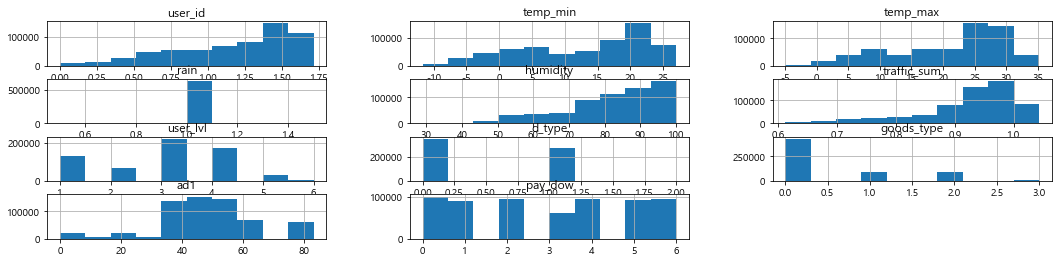

In [477]:
x_train.hist()

In [478]:
x_test

,user_id,temp_min,temp_max,rain,humidity,traffic_sum,user_lvl,d_type,goods_type,ad1,pay_dow
0,224,-4.0,6.1,1.0,69,8710203.0,1.0,0,2,49,6
1,232,16.4,21.8,1.0,86,6282435.0,4.0,1,1,51,0
2,232,9.0,19.0,1.0,91,9303245.0,4.0,1,0,49,5
3,232,7.5,18.2,1.0,91,9047418.0,4.0,1,0,49,1
4,232,14.8,18.6,1.0,97,9093256.0,4.0,1,0,49,6
...,...,...,...,...,...,...,...,...,...,...,...
255529,1830551,-12.7,-12.7,1.0,52,8324393.0,0.0,1,1,39,4
255530,1830570,-12.7,-12.7,1.0,52,8324393.0,0.0,1,1,19,4
255531,1830580,-12.7,-12.7,1.0,52,8324393.0,0.0,0,1,51,4
255532,1830589,-12.7,-12.7,1.0,52,8324393.0,0.0,1,1,49,4


array([[<AxesSubplot:title={'center':'user_id'}>,
        <AxesSubplot:title={'center':'temp_min'}>,
        <AxesSubplot:title={'center':'temp_max'}>],
       [<AxesSubplot:title={'center':'rain'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'traffic_sum'}>],
       [<AxesSubplot:title={'center':'user_lvl'}>,
        <AxesSubplot:title={'center':'d_type'}>,
        <AxesSubplot:title={'center':'goods_type'}>],
       [<AxesSubplot:title={'center':'ad1'}>,
        <AxesSubplot:title={'center':'pay_dow'}>, <AxesSubplot:>]],
      dtype=object)

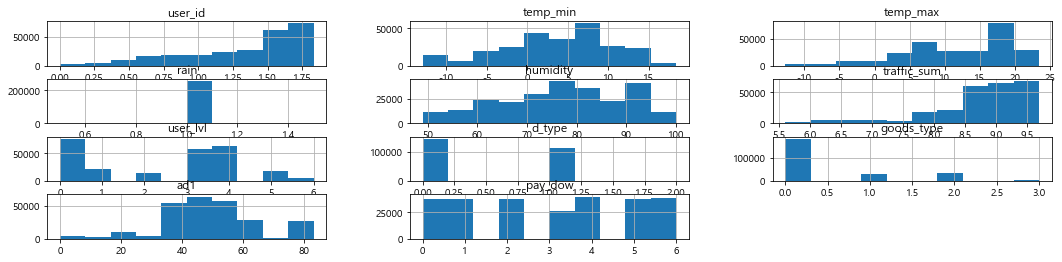

In [479]:
x_test.hist()

## 모델 생성 및 평가

### MAE 기준

In [480]:
# 트리계열 모델인 RandomForest, XGBoost, LightGBM 모델 성능 비교
# MAE 기준 가장 좋은 성능을 내는 모델 : LightGBM

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

models = [['RandomForest', RandomForestRegressor()], 
          ['XGBoost', XGBRegressor(n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(n_jobs=-1)]]

best_loss = np.inf
for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    current_loss = mean_absolute_error(y_test, y_pred)
    
    if current_loss < best_loss:
        best_loss  = current_loss
        best_model = [i, name, model]
    
    print(f'{name} Model Mean Absolute Error: {best_loss}')
    
print(f'Best Model: {best_model[-2]}, MAE : {best_loss}')

RandomForest Model Mean Absolute Error: 0.14545559495018276
XGBoost Model Mean Absolute Error: 0.07597006141639802
LightGBM Model Mean Absolute Error: 0.05340878456635232
Best Model: LightGBM, MAE : 0.05340878456635232


### MSE 기준

In [481]:
# 트리계열 모델인 RandomForest, XGBoost, LightGBM 모델 성능 비교
# MSE 기준 가장 좋은 성능을 내는 모델 : LightGBM

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

models = [['RandomForest', RandomForestRegressor()], 
          ['XGBoost', XGBRegressor(n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(n_jobs=-1)]]

best_loss = np.inf
for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    current_loss = mean_squared_error(y_test, y_pred)
    
    if current_loss < best_loss:
        best_loss  = current_loss
        best_model = [i, name, model]
    
    print(f'{name} Model Mean Squared Error: {best_loss}')
    
print(f'Best Model: {best_model[-2]}, MSE : {best_loss}')

RandomForest Model Mean Squared Error: 0.0638546295209248
XGBoost Model Mean Squared Error: 0.038639662661654174
LightGBM Model Mean Squared Error: 0.02924209582462269
Best Model: LightGBM, MSE : 0.02924209582462269


## 변수 중요도

In [483]:
# 최종 선택 모델의 변수 중요도 확인
best_model[-1].feature_importances_

array([877, 281, 199,   0, 145, 272, 309, 167, 166, 507,  77])

In [484]:
pd.DataFrame(sorted(zip(best_model[-1].feature_importances_, x_train.columns), reverse=True), columns=['Value','Feature'])

,Value,Feature
0,877,user_id
1,507,ad1
2,309,user_lvl
3,281,temp_min
4,272,traffic_sum
5,199,temp_max
6,167,d_type
7,166,goods_type
8,145,humidity
9,77,pay_dow


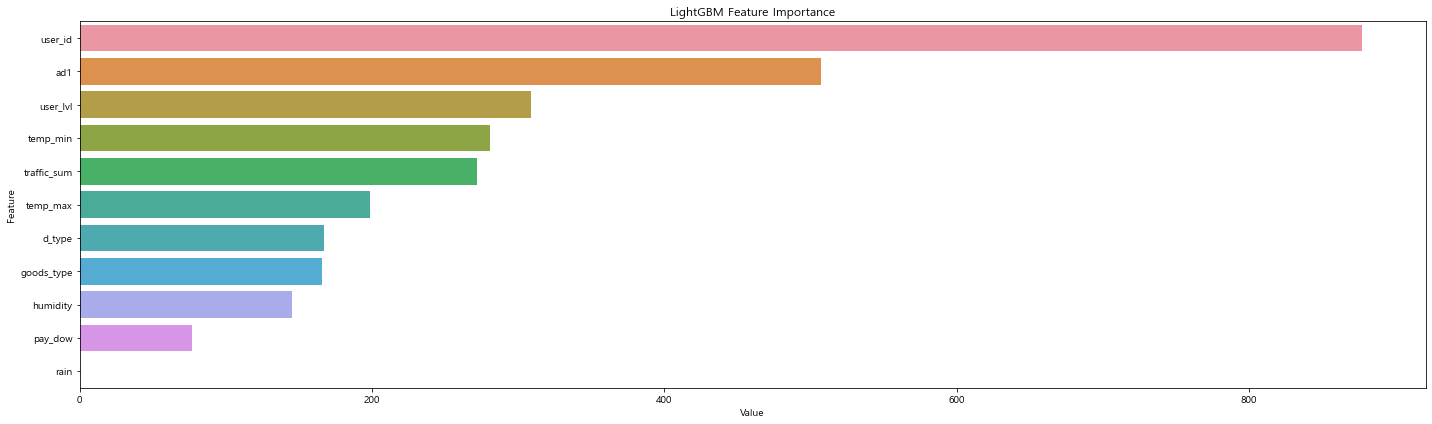

In [488]:
# Feature importance
feature_imp = pd.DataFrame(sorted(zip(best_model[-1].feature_importances_,x_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

⚡<b>인사이트</b>⚡
- 이용건수 예측에 user_id가 가장 큰 변수중요도를 가지며, 이는 전체 데이터셋에 1회만 이용한 유저가 많아 나타난 결과인 것으로 판단됨
- ad1의 중요도가 높게 나온 것은 heavy user가 같은 지역의 store을 주로 이용하는 경향이 있기 때문일 것으로 보임

# (추가분석) 모델을 통한 예측 - by user_id & pay_yearmonth

In [490]:
df_model['pay_yearmonth'] = df_model['date'].dt.strftime('%Y-%m')
df_model

,user_id,d_type,goods_type,date,count,ad1,pay_dow,temp_min,temp_max,rain,humidity,traffic_sum,user_lvl,pay_yearmonth
0,224,AA,A,2020-01-12,1,J,Sunday,-3.3,2.5,1.0,75,8033315.0,1.0,2020-01
1,224,AA,C,2020-12-09,1,J,Wednesday,-4.0,6.1,1.0,69,8710203.0,2.0,2020-12
2,232,BB,C,2020-01-19,1,GJ,Sunday,-0.3,4.9,1.0,91,8062593.0,1.0,2020-01
3,232,BB,C,2020-01-26,1,JRR,Sunday,-0.2,11.6,1.0,81,7371640.0,2.0,2020-01
4,232,BB,C,2020-01-27,1,JRR,Monday,5.0,7.4,1.0,66,6941343.0,3.0,2020-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878753,1830551,BB,B,2020-12-31,1,GN,Thursday,-12.7,-12.7,1.0,52,8324393.0,1.0,2020-12
878754,1830570,BB,B,2020-12-31,1,CY,Thursday,-12.7,-12.7,1.0,52,8324393.0,1.0,2020-12
878755,1830580,AA,B,2020-12-31,1,JRR,Thursday,-12.7,-12.7,1.0,52,8324393.0,1.0,2020-12
878756,1830589,BB,B,2020-12-31,1,J,Thursday,-12.7,-12.7,1.0,52,8324393.0,1.0,2020-12


In [491]:
# user_id, pay_yearmonth로 groupby하여 모델에 사용할 데이터셋 생성
# 기상, 교통량 관련 컬럼은 사용하지 않음

from scipy import stats

df_final = df_model.groupby(['user_id', 'pay_yearmonth'])['d_type','goods_type','ad1','pay_dow','user_lvl','count'].agg({
    'd_type' : lambda x: stats.mode(x)[0],
    'goods_type' : lambda x: stats.mode(x)[0],
    'ad1' : lambda x: stats.mode(x)[0],
    'pay_dow' : lambda x: stats.mode(x)[0],
    'user_lvl' : 'max',
    'count' : 'sum'}).reset_index()

df_final

<ipython-input-491-68b3ed033f9b>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_final = df_model.groupby(['user_id', 'pay_yearmonth'])['d_type','goods_type','ad1','pay_dow','user_lvl','count'].agg({


,user_id,pay_yearmonth,d_type,goods_type,ad1,pay_dow,user_lvl,count
0,224,2020-01,AA,A,J,Sunday,1.0,1
1,224,2020-12,AA,C,J,Wednesday,2.0,1
2,232,2020-01,BB,C,JRR,Sunday,3.0,4
3,232,2020-02,BB,A,J,Sunday,3.0,2
4,232,2020-03,BB,A,JRR,Sunday,3.0,2
...,...,...,...,...,...,...,...,...
375382,1830551,2020-12,BB,B,GN,Thursday,1.0,1
375383,1830570,2020-12,BB,B,CY,Thursday,1.0,1
375384,1830580,2020-12,AA,B,JRR,Thursday,1.0,1
375385,1830589,2020-12,BB,B,J,Thursday,1.0,1


<AxesSubplot:>

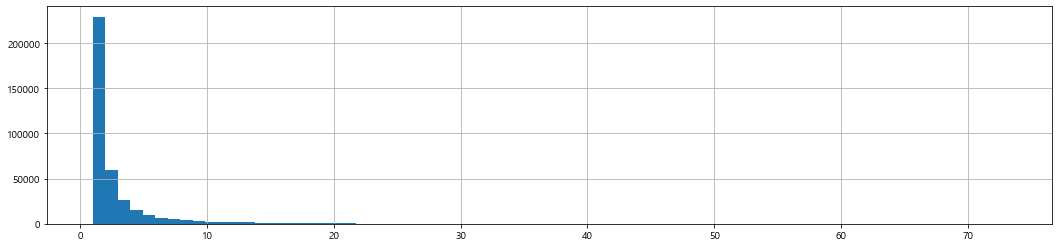

In [527]:
# 유저별, 월별 이용횟수는 1부터 73까지의 분포를 가짐
df_final['count'].hist(bins = 73)

## train, test set 나누기

In [522]:
# train, test set 구분을 위해 date컬럼 다시 생성
df_final['date'] = df_final['pay_yearmonth'].apply(lambda x : pd.to_datetime(x))
df_final

,user_id,pay_yearmonth,d_type,goods_type,ad1,pay_dow,user_lvl,count,date
0,224,2020-01,AA,A,J,Sunday,1.0,1,2020-01-01
1,224,2020-12,AA,C,J,Wednesday,2.0,1,2020-12-01
2,232,2020-01,BB,C,JRR,Sunday,3.0,4,2020-01-01
3,232,2020-02,BB,A,J,Sunday,3.0,2,2020-02-01
4,232,2020-03,BB,A,JRR,Sunday,3.0,2,2020-03-01
...,...,...,...,...,...,...,...,...,...
375382,1830551,2020-12,BB,B,GN,Thursday,1.0,1,2020-12-01
375383,1830570,2020-12,BB,B,CY,Thursday,1.0,1,2020-12-01
375384,1830580,2020-12,AA,B,JRR,Thursday,1.0,1,2020-12-01
375385,1830589,2020-12,BB,B,J,Thursday,1.0,1,2020-12-01


In [513]:
# train set (2020-01 ~ 2020-09)
df_train = df_final[df_final['date'] <= '2020-09-30']
df_train

,user_id,pay_yearmonth,d_type,goods_type,ad1,pay_dow,user_lvl,count,date
0,224,2020-01,AA,A,J,Sunday,1.0,1,2020-01-01
2,232,2020-01,BB,C,JRR,Sunday,3.0,4,2020-01-01
3,232,2020-02,BB,A,J,Sunday,3.0,2,2020-02-01
4,232,2020-03,BB,A,JRR,Sunday,3.0,2,2020-03-01
5,232,2020-04,BB,C,JRR,Saturday,4.0,4,2020-04-01
...,...,...,...,...,...,...,...,...,...
352605,1709914,2020-09,BB,B,GN,Wednesday,1.0,1,2020-09-01
352615,1709935,2020-09,AA,B,MP,Wednesday,1.0,1,2020-09-01
352616,1709942,2020-09,AA,B,BF,Wednesday,1.0,1,2020-09-01
352617,1709950,2020-09,BB,A,JRR,Wednesday,1.0,2,2020-09-01


In [514]:
# 유저별 train set의 최종 등급 user_lvl에 저장
user_lvl = df_train.groupby('user_id')['user_lvl'].max().reset_index()
user_lvl

,user_id,user_lvl
0,224,1.0
1,232,4.0
2,565,1.0
3,729,1.0
4,1448,2.0
...,...,...
130242,1709914,1.0
130243,1709935,1.0
130244,1709942,1.0
130245,1709950,1.0


In [515]:
# test set (2020-10 ~ 2020-12) 
df_test = df_final[df_final['date'] > '2020-09-30'].drop('user_lvl', axis = 1)
df_test

,user_id,pay_yearmonth,d_type,goods_type,ad1,pay_dow,count,date
1,224,2020-12,AA,C,J,Wednesday,1,2020-12-01
10,232,2020-10,BB,A,J,Friday,2,2020-10-01
11,232,2020-11,BB,A,J,Monday,2,2020-11-01
12,342,2020-10,AA,A,JRR,Saturday,1,2020-10-01
14,565,2020-11,AA,B,GN,Thursday,1,2020-11-01
...,...,...,...,...,...,...,...,...
375382,1830551,2020-12,BB,B,GN,Thursday,1,2020-12-01
375383,1830570,2020-12,BB,B,CY,Thursday,1,2020-12-01
375384,1830580,2020-12,AA,B,JRR,Thursday,1,2020-12-01
375385,1830589,2020-12,BB,B,J,Thursday,1,2020-12-01


In [516]:
# 유저별 train set의 최종등급을 test set의 user_lvl에 업데이트
df_test = df_test.merge(user_lvl, how = 'left', on = 'user_id')
df_test.loc[df_test['user_lvl'].isnull(), 'user_lvl'] = 0
df_test

,user_id,pay_yearmonth,d_type,goods_type,ad1,pay_dow,count,date,user_lvl
0,224,2020-12,AA,C,J,Wednesday,1,2020-12-01,1.0
1,232,2020-10,BB,A,J,Friday,2,2020-10-01,4.0
2,232,2020-11,BB,A,J,Monday,2,2020-11-01,4.0
3,342,2020-10,AA,A,JRR,Saturday,1,2020-10-01,0.0
4,565,2020-11,AA,B,GN,Thursday,1,2020-11-01,1.0
...,...,...,...,...,...,...,...,...,...
108130,1830551,2020-12,BB,B,GN,Thursday,1,2020-12-01,0.0
108131,1830570,2020-12,BB,B,CY,Thursday,1,2020-12-01,0.0
108132,1830580,2020-12,AA,B,JRR,Thursday,1,2020-12-01,0.0
108133,1830589,2020-12,BB,B,J,Thursday,1,2020-12-01,0.0


In [517]:
# 모델 예측에 불필요한 컬럼 지우기
x_train = df_train.drop(['count', 'date', 'pay_yearmonth'], axis = 1)
x_test = df_test.drop(['count', 'date', 'pay_yearmonth'], axis = 1)
y_train = df_train['count']
y_test = df_test['count']

In [518]:
# 범주형 변수 라벨인코딩 진행
x_train, x_test = labelencoding(x_train, x_test)

In [520]:
# 트리계열 모델인 RandomForest, XGBoost, LightGBM 모델 성능 비교
# MAE 기준 가장 좋은 성능을 내는 모델 : XGBoost

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

models = [['RandomForest', RandomForestRegressor()], 
          ['XGBoost', XGBRegressor(n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(n_jobs=-1)]]

best_loss = np.inf
for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    current_loss = mean_absolute_error(y_test, y_pred)
    
    if current_loss < best_loss:
        best_loss  = current_loss
        best_model = [i, name, model]
    
    print(f'{name} Model Mean Absolute Error: {best_loss}')
    
print(f'Best Model: {best_model[-2]}, MAE : {best_loss}')

RandomForest Model Mean Absolute Error: 1.530176928898781
XGBoost Model Mean Absolute Error: 1.5067885904239897
LightGBM Model Mean Absolute Error: 1.5067885904239897
Best Model: XGBoost, MAE : 1.5067885904239897


In [521]:
# 트리계열 모델인 RandomForest, XGBoost, LightGBM 모델 성능 비교
# MSE 기준 가장 좋은 성능을 내는 모델 : XGBoost

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

models = [['RandomForest', RandomForestRegressor()], 
          ['XGBoost', XGBRegressor(n_jobs=-1)], 
          ['LightGBM', LGBMRegressor(n_jobs=-1)]]

best_loss = np.inf
for i, (name, model) in enumerate(models):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    current_loss = mean_squared_error(y_test, y_pred)
    
    if current_loss < best_loss:
        best_loss  = current_loss
        best_model = [i, name, model]
    
    print(f'{name} Model Mean Squared Error: {best_loss}')
    
print(f'Best Model: {best_model[-2]}, MSE : {best_loss}')

RandomForest Model Mean Squared Error: 8.505251799300773
XGBoost Model Mean Squared Error: 8.181963629503361
LightGBM Model Mean Squared Error: 8.181963629503361
Best Model: XGBoost, MSE : 8.181963629503361


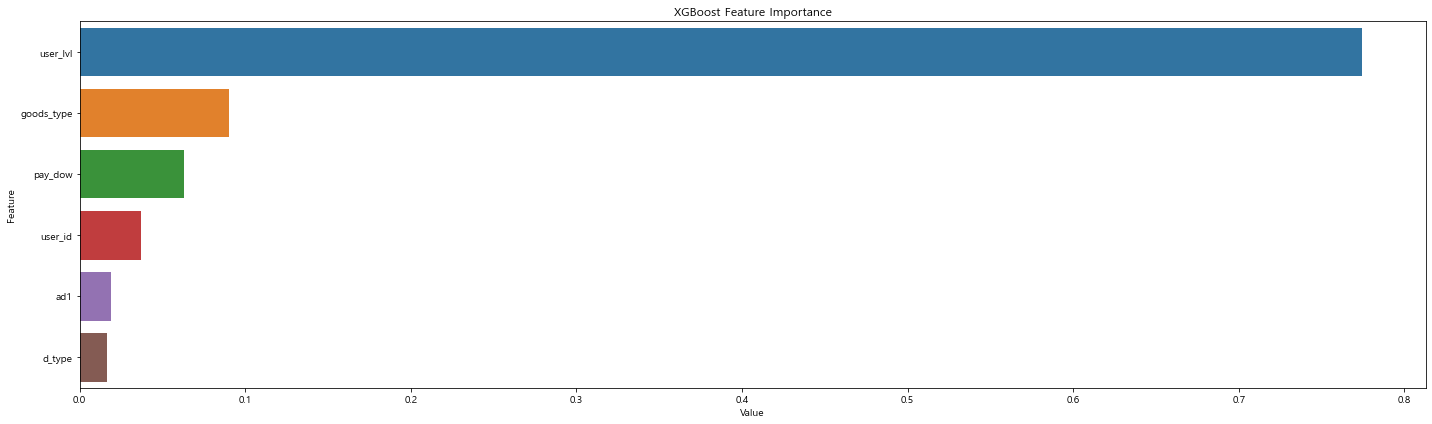

In [523]:
# Feature importance
feature_imp = pd.DataFrame(sorted(zip(best_model[-1].feature_importances_,x_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 6))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(20))
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

⚡<b>인사이트</b>⚡
- user_id, pay_yearmonth로 groupby한 데이터셋으로 유저별, 월별 이용건수를 예측하였을 때는 XGBoost가 가장 좋은 성능을 보임
- 유저의 등급을 나타내는 user_lvl이 압도적으로 높은 feature importance를 가짐